# Learning sampling pattern
Second version of the full algorithm:
- Several images possible
- Learning points (cartesian shots soon)

In [1]:
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN
import pysap
from pysap.data import get_sample_data
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from modopt.math.metrics import ssim
import matplotlib.pyplot as plt
import numpy as np


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
# Lower level imports
from LowerLevel.prox import prox_G,prox_F1_dual,prox_F2_dual
from LowerLevel.pdhg import pdhg
from LowerLevel.cost_utils import *

#Upper level imports
from scipy.sparse.linalg import cg,LinearOperator
import scipy
import time
from UpperLevel.L1norm import *
from UpperLevel.hessians import *
from scipy.optimize.lbfgsb import fmin_l_bfgs_b
from scipy.stats import norm

In [3]:
import nibabel as nib
import h5py

In [4]:
#Oasis image
all_images = [ "oasis_data/sub-OAS30001_ses-d0129_run-01_T1w.nii"]
              #,"../oasis_data/sub-OAS30278_ses-d1325_run-02_T1w.nii" ]
im = nib.load("oasis_data/sub-OAS30001_ses-d0129_run-01_T1w.nii")
im = im.get_fdata()

n = 70
Nimages = 2
images = [(1+0j)*im[ 30:30+n, 30:30+n, i ]for i in range(124,124+Nimages)]

In [5]:
x = np.linspace(0,n,n,endpoint=False)/n-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

m = convert_locations_to_mask(kspace_loc,(n,n))
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=(n,n),implementation='cpu')

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


### Creation of cartesian mask

In [6]:
x = np.linspace( -0.5, 0.5, n, endpoint = False )
p = np.array([norm.pdf(u,loc=0,scale=0.15) for u in x])
p /= np.sum(p)
y_sampled = np.random.choice( x, size=int(0.7*n), p=p, replace=False)#, p=p

In [7]:
cartesian_p = np.zeros(n**2+1)
cartesian_p[-1] = 5
for y in y_sampled:
    j=int((y+0.5)*n)
    cartesian_p[j*n:(j+1)*n] = np.ones((n,))
pysap.Image(data=np.reshape(cartesian_p[:-1],(n,n))).show()

In [8]:
#Wavelet
linear_op = WaveletN(wavelet_name="sym8",nb_scale=1,padding_mode = "periodization")
#linear_op = WaveletUD2(wavelet_id=24,nb_scale=3)

#param = {"pn1":p[-1],"epsilon":1e0,"gamma":1e-10}
param = {"epsilon":1e-7,"gamma":1e-10}
kspace_data = [(1+0j)*fourier_op.op(u0_mat)+0.1*np.mean(u0_mat)*np.random.randn(2*n*n).view(np.complex128) 
               for u0_mat in images]

In [9]:
print(ssim(fourier_op.adj_op(cartesian_p[:-1]*kspace_data[-1]),images[-1]))
pysap.Image(data=np.abs(fourier_op.adj_op(cartesian_p[:-1]*kspace_data[-1]))).show()

0.882133839323623


## Loss function and penalty

In [10]:
c = 1e-6
def L(u,u2):return c/2 * np.linalg.norm(u.flatten()-u2.flatten())**2
def Du_L(u,u2):return c*(u-u2)


beta = 1e2*c
def P(p):return beta*np.sum(p[:-1]*(2-p[:-1]))
def grad_P(p):
    Dp = np.zeros(n**2+1)
    Dp[:-1] = 2*beta*(1-p[:-1])
    return Dp

In [11]:
uk,norms,energy = pdhg(kspace_data[0] , cartesian_p ,
                             fourier_op = fourier_op,
                             linear_op = linear_op,
                             param = param,
                             maxit=50,
                             compute_energy = True,
                             verbose=0)
print(f"\nL(u(p))={L(uk,images[0])}\nP(p)={P(cartesian_p)}")

Sigma: 0.00022360679774997898 
Tau: 2236.06797749979


/home/guillaume/pysap-mri/Learning Sampling Pattern/LowerLevel/prox.py:17: RuntimeWarning: invalid value encountered in sqrt
  x/np.abs(x)*(gamma+gamma**2/2/c-gamma/c*np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))


Finished in 0.7358455657958984 seconds.

L(u(p))=25.417663441213808
P(p)=0.294


# Upper level energy

In [12]:
def E(pk,**kwargs):
    # Getting parameters
    images = kwargs.get("images",None)       
    kspace_data = kwargs.get("kspace_data",None)
    verbose = kwargs.get("verbose",0)
    if verbose>=0:print("\n\nEVALUATING E(p)")
    
    if images is None or len(images)<1:raise ValueError("At least one image is needed")
    if len(images)!=len(kspace_data):raise ValueError("Need as many images and kspace data")

    #Computing E(p)
    Nimages = len(images)
    Ep = P(pk)
    param["pn1"]=pk[-1]
    for i in range(Nimages):
        if verbose>=0:print(f"\nImage {i+1}:")
        u0_mat,y = images[i],kspace_data[i]
        if verbose>0:print("\nStarting PDHG")
        uk,_ = pdhg(y , pk , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = verbose)
        Ep += L(uk,u0_mat)/Nimages
    
    return Ep

In [13]:
E(cartesian_p,images = images, kspace_data = kspace_data)



EVALUATING E(p)

Image 1:
Sigma: 0.00022360679774997898 
Tau: 2236.06797749979
Finished in 0.44196367263793945 seconds.

Image 2:
Sigma: 0.00022360679774997898 
Tau: 2236.06797749979
Finished in 0.4294149875640869 seconds.


25.540447139065552

In [14]:
# -- Compute grad_L for one image --
# ----------------------------------
def grad_L(pk,**kwargs):
    # -- Getting parameters
    max_cgiter = kwargs.get("max_cgiter",3000)
    cgtol = kwargs.get("cgtol",1e-6)
    compute_conv = kwargs.get("compute_conv",False)
    u0_mat = kwargs.get("u0_mat",None)
    y = kwargs.get("y",None)
    verbose = kwargs.get("verbose",0)
    cg_conv = []
    
    if u0_mat is None:raise ValueError("A ground truth image u0_mat is needed")
    if y is None:raise ValueError("kspace data y are needed")
    
    
    # -- Compute uk from pk with lower level solver if not given
    if verbose>=0:print("\nStarting PDHG")
    param["pn1"]=pk[-1]
    uk,_ = pdhg(y , pk , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = verbose)
    
    # -- Defining linear operator from pk and uk
    def mv(w):
        w_complex = np.reshape( w[:n**2]+1j*w[n**2:] , (n,n) )
        fx = np.reshape(Du2_Etot( uk , pk , w_complex ,
                                   eps=param["epsilon"],
                                   fourier_op=fourier_op,
                                   y=y,
                                   linear_op=linear_op,
                                   gamma=param["gamma"]),(n**2,))
        return np.concatenate([np.real(fx),np.imag(fx)])
    lin = LinearOperator((2*n**2,2*n**2),matvec=mv)


    if verbose>=0:print("\nStarting Conjugate Gradient method")
    t1=time.time()
    B = np.reshape(Du_L(uk,u0_mat),(n**2,))
    B_real = np.concatenate([np.real(B),np.imag(B)])
    def cgcall(x):
        #CG callback function to plot convergence
        if compute_conv:cg_conv.append(np.linalg.norm(lin(x)-B_real)/np.linalg.norm(B_real))
    
    x_inter,convergence = scipy.sparse.linalg.cg(lin,B_real,tol=cgtol,maxiter=max_cgiter,callback=cgcall)
    if verbose>=0:print(f"Finished in {time.time()-t1}s - ||Ax-b||/||b||: {np.linalg.norm(lin(x_inter)-B_real)/np.linalg.norm(B_real)}")

    
    # -- Plotting
    if compute_conv:
        plt.plot(cg_conv)
        plt.yscale("log")
        plt.title("Convergence of the conjugate gradient")
        plt.xlabel("Number of iterations")
        plt.ylabel("||Ax-b||/||b||")
        #plt.savefig("Upper Level/CG_conv.png")
    
    
    if np.linalg.norm(lin(x_inter)-B_real)/np.linalg.norm(B_real)>1e-3: return np.zeros(pk.shape)
    else: return -Dpu_Etot(uk,pk,np.reshape( x_inter[:n**2]+1j*x_inter[n**2:] , (n,n) ),
                               eps=param["epsilon"],
                               fourier_op=fourier_op,
                               y=y,
                               linear_op=linear_op,
                               gamma=param["gamma"])

In [15]:
def grad_E(pk,**kwargs):
    # Getting parameters
    images = kwargs.get("images",None)       
    kspace_data = kwargs.get("kspace_data",None)
    verbose = kwargs.get("verbose",0)
    if verbose>=0:print("\n\nEVALUATING GRAD_E(p)")
    
    if images is None or len(images)<1:raise ValueError("At least one image is needed")
    if len(images)!=len(kspace_data):raise ValueError("Need as many images and kspace data")
        
    #Computing gradient
    Nimages = len(images)
    gEp = np.zeros(pk.shape)
    for i in range(Nimages):
        if verbose>=0:print(f"\nImage {i+1}:")
        gEp += grad_L(pk,u0_mat=images[i],y=kspace_data[i],**kwargs)
    
    #If gEp=0, CG didn't converge, so don't change pk so that L-BFGS stops
    if np.all(gEp == np.zeros(pk.shape)):return gEp
    else: return gEp+grad_P(pk)

1.0


EVALUATING GRAD_E(p)

Image 1:

Starting PDHG
Sigma: 33.73416851369791 
Tau: 0.014821767425421285
Finished in 0.5146474838256836 seconds.

Starting Conjugate Gradient method
Finished in 9.507558822631836s - ||Ax-b||/||b||: 9.978150679307731e-09

Image 2:

Starting PDHG
Sigma: 33.73416851369791 
Tau: 0.014821767425421285
Finished in 0.4242527484893799 seconds.

Starting Conjugate Gradient method
Finished in 10.601947784423828s - ||Ax-b||/||b||: 9.669067711482275e-09


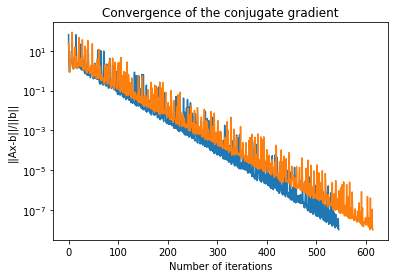

In [16]:
#Checking if conjugate gradient converges
p = np.random.rand(n**2+1)

p[-1]=1e0
print( p[ -1 ] )
gP = grad_E(p,images=images,kspace_data=kspace_data,max_cgiter=5000,cgtol=1e-8, compute_conv = True)

In [17]:
# Checking gradE
ptest = np.random.rand(n**2+1)
ptest[-1]=1e0

param["pn1"] = ptest[-1]
Eptest,gradEptest = E(ptest,images=images,kspace_data=kspace_data),grad_E(ptest,images=images,kspace_data=kspace_data)

p1 = np.random.rand(n**2+1)
tests = np.logspace(-10,0,30)
real_values = np.array([E(ptest+t*p1,images=images,kspace_data=kspace_data) for t in tests])
approx = np.array([Eptest+np.sum(gradEptest*t*p1) for t in tests])



EVALUATING E(p)

Image 1:
Sigma: 9.833789700105845 
Tau: 0.050845097896960144
Finished in 0.4370148181915283 seconds.

Image 2:
Sigma: 9.833789700105845 
Tau: 0.050845097896960144
Finished in 0.42360711097717285 seconds.


EVALUATING GRAD_E(p)

Image 1:

Starting PDHG
Sigma: 9.833789700105845 
Tau: 0.050845097896960144
Finished in 0.4467427730560303 seconds.

Starting Conjugate Gradient method
Finished in 9.049605131149292s - ||Ax-b||/||b||: 8.438848006680536e-07

Image 2:

Starting PDHG
Sigma: 9.833789700105845 
Tau: 0.050845097896960144
Finished in 0.5477936267852783 seconds.

Starting Conjugate Gradient method
Finished in 14.835201740264893s - ||Ax-b||/||b||: 9.977105213826382e-07


EVALUATING E(p)

Image 1:
Sigma: 9.833789707621207 
Tau: 0.05084509785810236
Finished in 0.3996281623840332 seconds.

Image 2:
Sigma: 9.833789707621207 
Tau: 0.05084509785810236
Finished in 0.3973567485809326 seconds.


EVALUATING E(p)

Image 1:
Sigma: 9.83378971673145 
Tau: 0.05084509781099832
Finishe

6.113617568624617


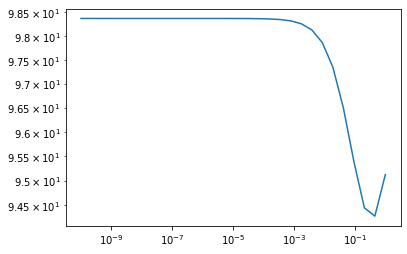

In [18]:
print(Eptest)
plt.plot(tests,abs((real_values-approx))/tests)
plt.xscale("log")
plt.yscale("log")

# L-BFGS-B

In [19]:
p0 = np.random.rand(n**2+1)
p0[-1] = 5
param["epsilon"] = 1e-7

# Callback function
niter = 0
energy_upper = [E(p0,images=images,kspace_data=kspace_data)]
alphas = [p0[-1]]
def fcall(x):
    global uk,niter
    niter += 1
    Ep = E(x,images=images,kspace_data=kspace_data, verbose=-1)
    energy_upper.append(Ep)
    alphas.append(x[-1])
    print("\033[1m" + f"\n{niter} iterations: E(p)={Ep}, alpha={x[-1]}\n\n" + "\033[0m")



EVALUATING E(p)

Image 1:
Sigma: 37.7792908201617 
Tau: 0.013234764050498395
Finished in 0.45521974563598633 seconds.

Image 2:
Sigma: 37.7792908201617 
Tau: 0.013234764050498395
Finished in 0.43021249771118164 seconds.


In [20]:
niter = 0
energy_upper = [E(p0,images=images,kspace_data=kspace_data,verbose=-1)]
alphas = [p0[-1]]
pf,Emin,info = fmin_l_bfgs_b(lambda x:E(x,images=images,kspace_data=kspace_data,verbose=-1),p0,
                             lambda x:grad_E(x,images=images,kspace_data=kspace_data,verbose=-1),
                             bounds=[(0,1)]*n**2+[(1e-10,np.inf)],pgtol=1e-6,
                             maxfun=20,maxiter=20,maxls=2,
                             callback = fcall)


1 iterations: E(p)=57.05963053815772, alpha=0.8570740671057782



2 iterations: E(p)=37.001926901250755, alpha=0.7144733918579398



3 iterations: E(p)=27.680898847535097, alpha=0.6340063780311347



4 iterations: E(p)=18.21901769298552, alpha=0.534626236740231



5 iterations: E(p)=12.65643566199827, alpha=0.4668665262935927



6 iterations: E(p)=8.808717584246754, alpha=0.42650496593227516



7 iterations: E(p)=6.325884856599238, alpha=0.42784720028526785



8 iterations: E(p)=4.885170873616278, alpha=0.4789531854005739



9 iterations: E(p)=4.098825792788191, alpha=0.5319073822170329



10 iterations: E(p)=3.2771220239859327, alpha=0.4942524083276401



11 iterations: E(p)=3.1944154851356723, alpha=0.6353140898117621



12 iterations: E(p)=2.1280217958553767, alpha=0.58315760867023



13 iterations: E(p)=1.912014807868976, alpha=0.8905688083200324



14 iterations: E(p)=1.6475748461903483, alpha=1.5352833274106499



15 iterations: E(p)=1.4493065796409959, alpha=2.742371735214487



78.89216930500078 1.2634486708776793


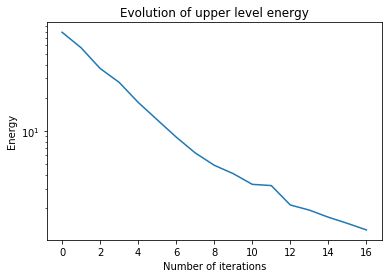

In [21]:
print(energy_upper[0],energy_upper[-1])
plt.plot(energy_upper)
plt.title("Evolution of upper level energy")
plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Multiple images/10 images/convergence.png")

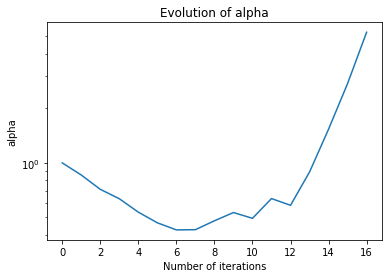

In [22]:
plt.plot(alphas)
plt.title("Evolution of alpha")
plt.xlabel("Number of iterations")
plt.ylabel("alpha")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Multiple images/10 images/alpha.png")

In [23]:
print(pf[-1])
ceiled_pf = np.where(pf>0.5,1,0)
pysap.Image(data=np.reshape(pf[:-1],(n,n))).show()

5.263390019480873


In [24]:
P(pf),E(pf,images=images,kspace_data=kspace_data),np.sum(ceiled_pf)



EVALUATING E(p)

Image 1:
Sigma: 37.02401630901807 
Tau: 0.013504747724471296
Finished in 0.5440962314605713 seconds.

Image 2:
Sigma: 37.02401630901807 
Tau: 0.013504747724471296
Finished in 0.4030876159667969 seconds.


(0.35934512528802304, 1.2634486708776793, 2855)

In [25]:
param["pn1"]=pf[-1]
#itest<Nimages
itest = 0
uk,norms,energy,ssims = pdhg(kspace_data[itest] , pf , fourier_op = fourier_op , linear_op = linear_op ,
                             param = param , maxit = 200 , ground_truth = images[itest] , 
                             compute_energy = True , verbose = 0)

Sigma: 37.02401630901807 
Tau: 0.013504747724471296
Finished in 2.517537832260132 seconds.


0.9343385049355546


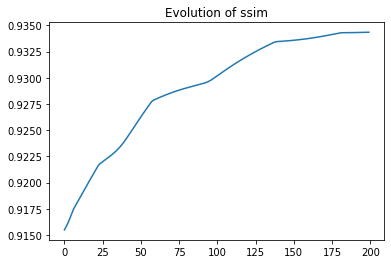

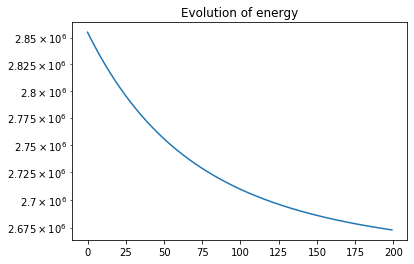

In [26]:
print(ssim(uk,images[itest]))

plt.figure()
plt.plot(ssims)
plt.title("Evolution of ssim")
plt.show()

plt.figure()
plt.plot(energy)
plt.title("Evolution of energy")
plt.yscale("log")
plt.show()

pysap.Image(data=uk).show()

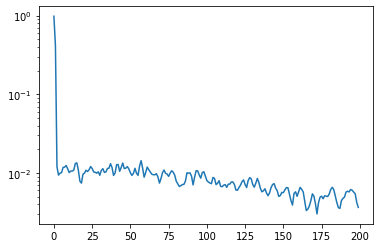

In [27]:
plt.plot(norms)
plt.yscale("log")

In [29]:
mean_ssim = 0
for itest in range(Nimages):
    print("\n")
    uk,norms = pdhg(kspace_data[itest] , ceiled_pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1)
    mean_ssim += ssim(uk,images[itest])
print(f"\nMean ssim: {mean_ssim/Nimages}")






Mean ssim: 0.9069826690935261
